# Stepwiese Runtime Comparisons on Real Data

This notebook checks the performance of feature batching vs standard training. It makes use of data from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5746044/.

In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import warnings
import scipy
import time
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
import batchglm.api as glm
import scanpy as sc

np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")
logging.getLogger("tensorflow").setLevel(logging.INFO)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

/home/mario/miniconda3/envs/batchglm_tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mario/miniconda3/envs/batchglm_tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mario/miniconda3/envs/batchglm_tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mario/miniconda3/envs/

## Setup

### I/O Settings

In [3]:
in_dir = '/home/mario/PSC19/'
out_dir = '/home/mario/PSC19/'
matrix_file = 'riesenfeld17_il25nmu_counts.mtx'
annot_file = 'riesenfeld17_il25nmu_annot.csv'
genes_file = 'riesenfeld17_il25nmu_genes.csv'

### Parameters

In [5]:
plot_figures = True  # specify whether figures should be printed.
save_figures = False # specify whether figures should be saved.

quick_scale = False  # determine whether the variance model should be trained
autograd = False     # specfify whether to use closed form gradients or TensorFlow's built-in autograd

## Generate Input Data for BatchGLM

### Read in Counts Data

scipy's mmread function takes a while here, approx. 90 seconds.

In [7]:
x_orig = scipy.io.mmread(in_dir+matrix_file).tocsc()
x = x_orig.transpose().toarray()
x = x.astype(dtype='int')
print(x.shape)

(35670, 13711)


We take the `n` highest expressed genes:

In [8]:
n = 100
counts = np.sum(x, axis=0)
counts_sorted = counts.argsort()
highest_n = counts_sorted[-n:]
x_n = x[:,highest_n]
print(x_n.shape)

(35670, 100)


### Downsampling

35670 observations are way too much to do general runtimes analyses at this point in time. We downsample to `n_obs` observations by taking random row indices from x.

In [9]:
n_obs = 1000
idx = np.random.choice(x.shape[0], n_obs, replace=False)
x_n = x_n[idx]
print(x_n.shape)

(1000, 100)


### Create Design matrices

Read annotation csv data with pandas

In [10]:
annot_data = pd.read_csv(in_dir+annot_file)
annot_data= annot_data.loc[idx]
annot_data.head()

,Unnamed: 0,cell,sample,cond,rep
26564,NMU_rep1.ACTTGTTAGCAATCTC,NMU_rep1.ACTTGTTAGCAATCTC,NMU_rep1,NMU,rep1
2384,IL25_rep1.IL25_rep1.GAGTCCGCACGTTGGC,IL25_rep1.GAGTCCGCACGTTGGC,IL25_rep1,IL25,rep1
4790,IL25_rep2.CACAGGCTCTGCAGTA,IL25_rep2.CACAGGCTCTGCAGTA,IL25_rep2,IL25,rep2
13762,control_rep2.CGCGTTTAGAATTCCC,control_rep2.CGCGTTTAGAATTCCC,control_rep2,control,rep2
29467,NMU_rep1.GGGACCTCAGCTTCGG,NMU_rep1.GGGACCTCAGCTTCGG,NMU_rep1,NMU,rep1


In [11]:
annot_data.shape

(1000, 5)

In [12]:
annot_data['sample'].unique()

array(['NMU_rep1', 'IL25_rep1', 'IL25_rep2', 'control_rep2',
       'control_rep1', 'NMU_IL25_rep1', 'NMU_IL25_rep2', 'NMU_rep2'],
      dtype=object)

In [13]:
annot_data['cond'].unique()

array(['NMU', 'IL25', 'control', 'NMU_IL25'], dtype=object)

Data consists of a total of `n_obs` observations, with 4 conditions, each of which is given in two batches.

In [14]:
intercept = np.ones(n_obs)
cond_IL25 = np.array(annot_data['cond'] == 'IL25', dtype='int')
cond_NMU = np.array(annot_data['cond'] == 'NMU', dtype='int')
cond_NMU_IL25 = np.array(annot_data['cond'] == 'NMU_IL25', dtype='int')
#batch = np.array(annot_data['rep'] == 'rep2', dtype='int')

The design matrix can be given by an intercept, representing condition control and batch 0 + 3 condition columns and a batch column.
It has the shape n_obs x (intercept, IL25, NMU, IL25_NMU, batch)

In [15]:
design_loc = np.stack((intercept, cond_IL25, cond_NMU, cond_NMU_IL25), axis=-1)
print(design_loc)
print(design_loc.shape)


[[1. 0. 1. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 ...
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 0.]]
(1000, 4)


`design_loc` and `design_scale` are the same in this case, so we just assign it here: 

In [16]:
design_scale = design_loc

### Create Size Factors

In [17]:
size_factors = np.sum(x_n,axis=1)/(n_obs)
size_factors = size_factors / np.mean(size_factors)
print(size_factors.shape)

(1000,)


Check for zeros to identify potential columns with only zeros (features without any counts):

In [18]:
non_zero_idx = np.where(size_factors > 0)[0]
print(np.where(size_factors == 0))

(array([], dtype=int64),)


Empty array, thus all observations have at least 1 count. 

### Create Input Data

In [19]:
input_data = glm.models.glm_nb.InputDataGLM(data=x_n, design_loc=design_loc, design_scale=design_scale, size_factors=size_factors)

## Fit Models with IRLS

In [22]:
estimator = glm.models.glm_nb.Estimator(input_data, init_a = "standard", init_b = "standard", quick_scale=quick_scale)
estimator.initialize()
estimator.train(batched_model=False, batch_size=1000, optimizer="irls_gd_tr", learning_rate=1e-2, 
            convergence_criteria="both", stopping_criteria=30, autograd=autograd, featurewise=False, benchmark=True)
standard_irls_runtimes = estimator.times.copy()
estimator.initialize()
estimator.train(batched_model=False, batch_size=1000, optimizer="irls_gd_tr", learning_rate=1e-2, 
            convergence_criteria="both", stopping_criteria=30, autograd=autograd, featurewise=False, benchmark=True)
fb_irls_runtimes = estimator.times.copy()
irls_converged = estimator.converged.copy()

(1000,)
step 0
Step: 3 loss: 315.6912285029259, converged 17, updated 89, (logs: 17, grad: 0, x_step: 0)
Step: 4 loss: 315.6912221220984, converged 43, updated 33, (logs: 26, grad: 0, x_step: 0)
Step: 5 loss: 315.69122212186204, converged 47, updated 4, (logs: 4, grad: 0, x_step: 0)
step 10
Step: 16 loss: 315.69122212186187, converged 50, updated 3, (logs: 3, grad: 0, x_step: 0)
Step: 17 loss: 315.69122212186187, converged 55, updated 5, (logs: 5, grad: 0, x_step: 0)
Step: 18 loss: 315.69122212186187, converged 61, updated 6, (logs: 6, grad: 0, x_step: 0)
Step: 19 loss: 315.69122212186187, converged 71, updated 10, (logs: 10, grad: 0, x_step: 0)
step 20
Step: 20 loss: 315.69122212186187, converged 78, updated 7, (logs: 7, grad: 0, x_step: 0)
Step: 21 loss: 315.69122212186187, converged 83, updated 5, (logs: 5, grad: 0, x_step: 0)
Step: 22 loss: 315.69122212186187, converged 87, updated 4, (logs: 4, grad: 0, x_step: 0)
Step: 23 loss: 315.69122212186187, converged 89, updated 2, (logs: 2

[ 0. 91. 91. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 94. 94.
 94. 94. 95. 97. 97. 97. 97. 97. 97. 97. 97. 97.]


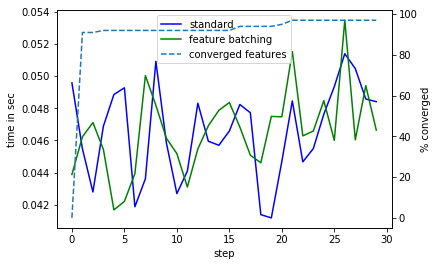

In [24]:
if plot_figures:
    n_features=n
    normed_values2 = np.array(irls_converged)/n_features*100
    print(normed_values2)
    #normed_values = np.array(estimator.converged)*(est1_rt_max/n_features)

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    a = ax1.plot(range(len(standard_irls_runtimes)), standard_irls_runtimes, 'b', label="standard")
    b = ax1.plot(range(len(fb_irls_runtimes)),fb_irls_runtimes,'g', label="feature batching")
    c = ax2.plot(range(len(irls_converged)),normed_values2,'--', label="converged features")

    lns = a+b+c
    labs = [l.get_label() for l in lns]
    ax1.set_xlabel("step")
    ax1.set_ylabel('time in sec')
    ax2.set_ylabel('% converged')
    ax1.legend(lns,labs)
    if save_figures:
        plt.savefig(out_dir+'irls_real_saving.pdf', bbox_inches="tight")
    plt.show()

## Fit Models with ADAM

In [29]:
estimator2 = glm.models.glm_nb.Estimator(input_data, init_a = "standard", init_b = "standard", quick_scale=quick_scale)
estimator2.initialize()
estimator2.train(batched_model=False, batch_size=1000, optimizer="adam", learning_rate=1e-2, 
            convergence_criteria="all_converged", stopping_criteria=30, autograd=autograd, featurewise=False, benchmark=True)
standard_adam_runtimes = estimator2.times.copy()
estimator2.initialize()
estimator2.train(batched_model=False, batch_size=1000, optimizer="adam", learning_rate=1e-2, 
            convergence_criteria="all_converged", stopping_criteria=30, autograd=autograd, featurewise=False, benchmark=True)
fb_adam_runtimes = estimator2.times.copy()
adam_converged = estimator2.converged.copy()

(1000,)
step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
Step: 243 loss: 311.2138761882983, converged 1, updated 100, (logs: 1, grad: 0, x_step: 0)
Step: 246 loss: 311.2114601734431, converged 2, updated 99, (logs: 1, grad: 0, x_step: 0)
step 250
Step: 251 loss: 311.20757999380965, converged 3, updated 98, (logs: 1, grad: 0, x_step: 0)
step 260
step 270
step 280
step 290
Step: 297 loss: 311.17876589601275, converged 4, updated 97, (logs: 1, grad: 0, x_step: 0)
step 300
Step: 308 loss: 311.17329469912164, converged 5, updated 96, (logs: 1, grad: 0, x_step: 0)
step 310
step 320
step 330
step 340
step 350
step 360
step 370
Step: 372 loss: 311.14861349689403, converged 6, updated 95, (logs: 1, grad: 0, x_step: 0)
step 380
step 390
Step: 396 loss: 311.14169982677754, converged 7, updated 94, (logs: 1, grad: 0, x_step: 0)
step 40

step 2240
step 2250
step 2260
Step: 2267 loss: 311.08032246485146, converged 68, updated 33, (logs: 1, grad: 0, x_step: 0)
step 2270
step 2280
step 2290
step 2300
Step: 2300 loss: 311.079942902769, converged 69, updated 32, (logs: 1, grad: 0, x_step: 0)
step 2310
step 2320
step 2330
step 2340
step 2350
step 2360
step 2370
Step: 2370 loss: 311.0797834418091, converged 70, updated 31, (logs: 1, grad: 0, x_step: 0)
step 2380
step 2390
Step: 2392 loss: 311.07973961264275, converged 71, updated 30, (logs: 1, grad: 0, x_step: 0)
step 2400
step 2410
step 2420
step 2430
step 2440
Step: 2441 loss: 311.07965900983646, converged 72, updated 29, (logs: 1, grad: 0, x_step: 0)
step 2450
step 2460
step 2470
step 2480
step 2490
step 2500
step 2510
step 2520
step 2530
step 2540
step 2550
step 2560
step 2570
step 2580
step 2590
step 2600
step 2610
step 2620
step 2630
Step: 2639 loss: 311.07944541528485, converged 73, updated 28, (logs: 1, grad: 0, x_step: 0)
step 2640
step 2650
step 2660
step 2670
Step:

step 7490
step 7500
step 7510
step 7520
step 7530
step 7540
step 7550
step 7560
step 7570
step 7580
step 7590
step 7600
step 7610
step 7620
step 7630
step 7640
step 7650
step 7660
step 7670
Step: 7678 loss: 311.07804986488475, converged 100, updated 1, (logs: 1, grad: 0, x_step: 0)
step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
Step: 243 loss: 311.2138761882978, converged 1, updated 100, (logs: 1, grad: 0, x_step: 0)
Step: 246 loss: 311.2114601734427, converged 2, updated 99, (logs: 1, grad: 0, x_step: 0)
step 250
Step: 251 loss: 311.2075799938097, converged 3, updated 98, (logs: 1, grad: 0, x_step: 0)
step 260
step 270
step 280
step 290
Step: 297 loss: 311.1787658960135, converged 4, updated 97, (logs: 1, grad: 0, x_step: 0)
step 300
Step: 308 loss: 311.1732946991218, converged 5, updated 96, (logs: 1, grad: 0, x_step: 0

step 2000
Step: 2008 loss: 311.08098710586233, converged 67, updated 34, (logs: 1, grad: 0, x_step: 0)
step 2010
step 2020
step 2030
step 2040
step 2050
Step: 2058 loss: 311.08050196139027, converged 68, updated 33, (logs: 1, grad: 0, x_step: 0)
step 2060
step 2070
step 2080
step 2090
step 2100
step 2110
step 2120
step 2130
step 2140
step 2150
step 2160
step 2170
step 2180
step 2190
step 2200
step 2210
step 2220
step 2230
step 2240
step 2250
step 2260
Step: 2267 loss: 311.07997753803886, converged 69, updated 32, (logs: 1, grad: 0, x_step: 0)
step 2270
step 2280
step 2290
step 2300
Step: 2300 loss: 311.0801706308706, converged 70, updated 31, (logs: 1, grad: 0, x_step: 0)
step 2310
step 2320
step 2330
step 2340
step 2350
step 2360
step 2370
step 2380
Step: 2383 loss: 311.07978078019056, converged 71, updated 30, (logs: 1, grad: 0, x_step: 0)
step 2390
step 2400
step 2410
step 2420
step 2430
step 2440
Step: 2441 loss: 311.0796590363508, converged 72, updated 29, (logs: 1, grad: 0, x_ste

[  0.   0.   0. ...  99.  99. 100.]


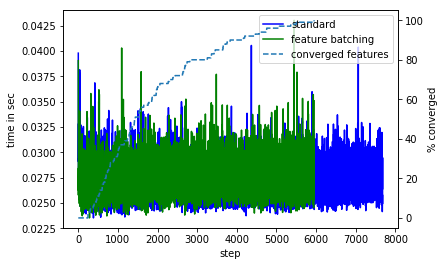

In [30]:
if plot_figures:
    n_features=n
    normed_values2 = np.array(adam_converged)/n_features*100
    print(normed_values2)
    #normed_values = np.array(estimator.converged)*(est1_rt_max/n_features)

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    a = ax1.plot(range(len(standard_adam_runtimes)), standard_adam_runtimes, 'b', label="standard")
    b = ax1.plot(range(len(fb_adam_runtimes)),fb_adam_runtimes,'g', label="feature batching")
    c = ax2.plot(range(len(adam_converged)),normed_values2,'--', label="converged features")

    lns = a+b+c
    labs = [l.get_label() for l in lns]
    ax1.set_xlabel("step")
    ax1.set_ylabel('time in sec')
    ax2.set_ylabel('% converged')
    ax1.legend(lns,labs)
    if save_figures:
        plt.savefig(out_dir+'adam_real_saving.pdf', bbox_inches="tight")
    plt.show()

In [28]:
standard_adam_runtimes

[0.043882131576538086,
 0.04622054100036621,
 0.047107696533203125,
 0.045432329177856445,
 0.04167771339416504,
 0.042203426361083984,
 0.0439298152923584,
 0.05002617835998535,
 0.048181772232055664,
 0.046135902404785156,
 0.04517626762390137,
 0.04309797286987305,
 0.04546952247619629,
 0.046910762786865234,
 0.04786539077758789,
 0.0483553409576416,
 0.046831369400024414,
 0.04507851600646973,
 0.04460477828979492,
 0.047490596771240234,
 0.04746437072753906,
 0.05152273178100586,
 0.046280622482299805,
 0.04658079147338867,
 0.04847002029418945,
 0.04600095748901367,
 0.053468942642211914,
 0.04603266716003418,
 0.049402475357055664,
 0.04663443565368652]